In [1]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from mat_utils import *
from block_matrix import *
from experiments.thermal.thm_models import make_model
import porepy as pp


model = make_model(
    {
        "geometry": 2,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore




Sim time: 0, Dt: 0.5
sticking: 43, sliding: 0, open: 0


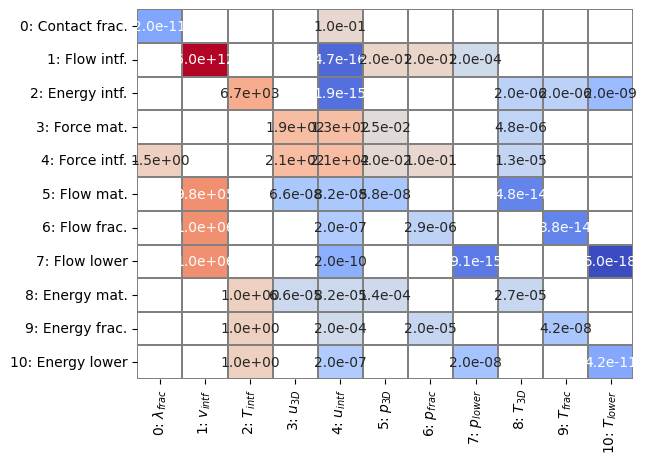

In [2]:
data = load_data(f"../../stats/{model.simulation_name()}.json")
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    data, 0, "../../matrices"
)
model.linear_system = mat, rhs
model.bmat.mat = mat
J = model.bmat[:]
J.plot_max()

Solve  took: 0.02
True residual: 1.6739429224922947e-11
PETSc Converged Reason: 2


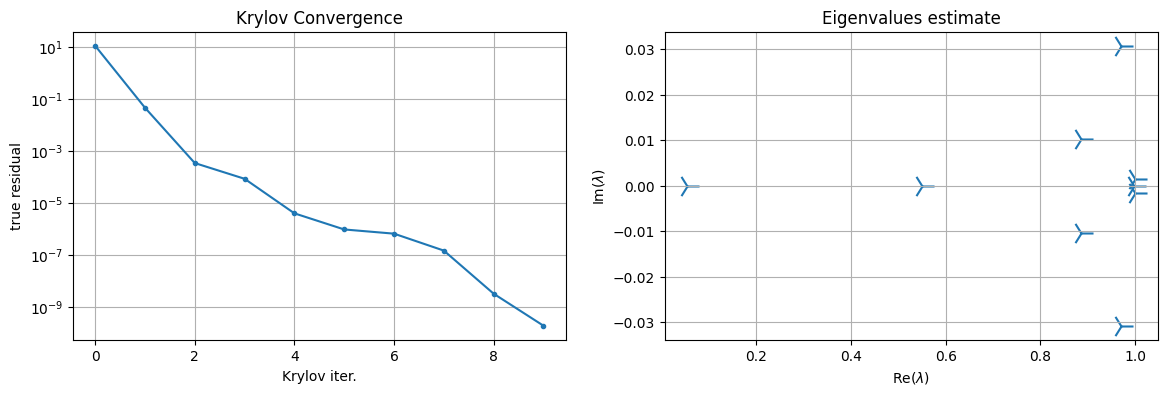

In [10]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space


solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        right_transformations=[
            lambda bmat: model.Qright(contact_group=model.CONTACT_GROUP, u_intf_group=4),
            lambda bmat: make_scaling(bmat, scale_groups=[7, 10]),
        ],
        preconditioner=FieldSplitScheme(
            # Exactly eliminate contact mechanics (assuming linearly-transformed system)
            groups=[0],
            solve=lambda bmat: inv_block_diag(mat=bmat[[0]].mat, nd=model.nd),
            complement=FieldSplitScheme(
                groups=[1],
                solve=lambda bmat: PetscILU(bmat[[1]].mat),
                invertor=lambda bmat: extract_diag_inv(bmat[[1]].mat),
                complement=FieldSplitScheme(
                    groups=[2],
                    solve=lambda bmat: PetscILU(bmat[[2]].mat),
                    invertor=lambda bmat: extract_diag_inv(bmat[[2]].mat),
                    complement=FieldSplitScheme(
                        # Eliminate elasticity. Use AMG to solve linear systems and fixed
                        # stress to approximate inverse.
                        groups=[3, 4],
                        solve=lambda bmat: PetscAMGMechanics(
                            mat=bmat[[3, 4]].mat,
                            dim=model.nd,
                            null_space=build_mechanics_near_null_space(model),
                        ),
                        invertor_type="physical",
                        invertor=lambda bmat: make_fs_analytical(
                            model,
                            bmat,
                            p_mat_group=5,
                            p_frac_group=6,
                            groups=[5, 6, 7, 8, 9, 10],
                        ).mat,
                        complement=MultiStageScheme(
                            # CPR for P-T coupling
                            groups=[5, 6, 7, 8, 9, 10],
                            stages=[
                                lambda bmat: RestrictedOperator(
                                    bmat,
                                    solve_scheme=FieldSplitScheme(
                                        groups=[5, 6, 7],
                                        solve=lambda bmat: PetscAMGFlow(bmat.mat),
                                    ),
                                ),
                                lambda bmat: PetscILU(bmat.mat),
                            ],
                        ),
                    ),
                ),
            ),
        ),
    ),
)